# Projektna naloga: Analiza filmov in njihovih žanrov

# Sodelujoči
- [Domen Dolanc](https://github.com/DomenDolanc)
- [Tomaž Martinčič](https://github.com/tm1897)
- [Žiga Klopčič](https://github.com/klopcic)

# Povezave
- [Osnutek](osnutek.md)
- [Aplikacija prikaz žanrov na zemljevidu skozi čas](map.html)


------------------

# Cilj raziskave
Analiza filmov in napovedovanje njihove uspešnosti.
Vizualno bomo predstavili rezultate naše raziskave v kateri bomo odgovorili na spodnja vprašanja:

- Kaj vse vpliva na uspešnost filma?
- Analiza vložka in dobička glede na žanr.
- Analiza vložka in dobička glede na čas.

V sklopu naše raziskave bomo naredili aplikacijo, ki bo poizkušala napovedovati uspešnost filma. Pripravili bomo tudi animacijo, ki bo prikazovala popularnost žanrov na zemljevidu skozi čas.

#### Uporabljene knjižnice

- Orange
- collections
- matplotlib
- numpy
- json
- pandas
- dateutil
- EasyMoney

# Podatki
Datoteke formata CSV vsebujejo podatke o filmih, ključnih besedah, igralcih in produkcijski ekipi.
[Povezava do podatkov.](https://www.kaggle.com/rounakbanik/the-movies-dataset/data)


### Podroben opis podatkov

### Filmi
-   `movies_metadata.csv` vsebuje podatke o filmih:

Atribut | Tip | Opis
-------- | -------- | --------
id  | Numeric | Identifikacijski atribut
belongs_to_collection   | String | Pripadajoča kolekcija
budget  | Numeric | Proračun namenjen izdelavi filma
genres  | String | Žanri
imdb_id | String | ID v sistemu imdb
original_language   | String | Originalen jezik
original_title  | String | Originalen naslov
overview    | String | Povzetek
popularity  | Numeric | Popularnost
production_companies    | String | Produkcijska podjetja
production_countries    | String | Produkcijske države
release_date    | DateTime | Datum izida
revenue | Numeric | Prihodki
runtime | Numeric | Dolžina
spoken_languages    | String | Jezik filma
status  | String | Stanje - ali je filem že izšel
title   | String | Naslov
vote_average    | Numeric | Povprečje ocen
vote_count  | Numeric | Število ocen

# Raziskava

In [1]:
import warnings
warnings.filterwarnings("ignore")
from Orange.data import Table
from collections import defaultdict
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
from matplotlib.ticker import FuncFormatter
from dateutil.parser import parse
from matplotlib.legend_handler import HandlerLine2D
from easymoney.money import EasyPeasy

In [2]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def millions(x, pos):
    return '%1dM' % (x*1e-6)


def parse_year(date):
    date = str(date).split("-")
    if len(date) < 3:
        return 2020
    else:
        return int(date[0])

def set_year(date):
    date1 = str(date).split("-")
    if len(date1) < 3:
        return 200000
    else:
        return date


In [3]:
movies = Table('data/movies_tab.tab')

In [4]:
revenue = []
vote_count = []

for movie in movies:
    if is_number(movie["vote_count"].value) and is_number(movie["revenue"].value):
        if int(movie["vote_count"].value) > 0 and int(movie["revenue"].value) > 0:
            revenue.append(int(movie["revenue"].value))
            vote_count.append(int(movie["vote_count"].value))
i = 0
num = 100
avg_revenue = []
avg_vote_count = []
while(i+num < len(revenue)):
    sum_rev = 0
    sum_vote = 0
    for j in range(num):
        sum_rev += revenue[j+i]
        sum_vote += vote_count[j+i]    
    avg_revenue.append(sum_rev/num)
    avg_vote_count.append(sum_vote/num)
    i+=num
fit_vr = np.polyfit(avg_vote_count, avg_revenue, 1)


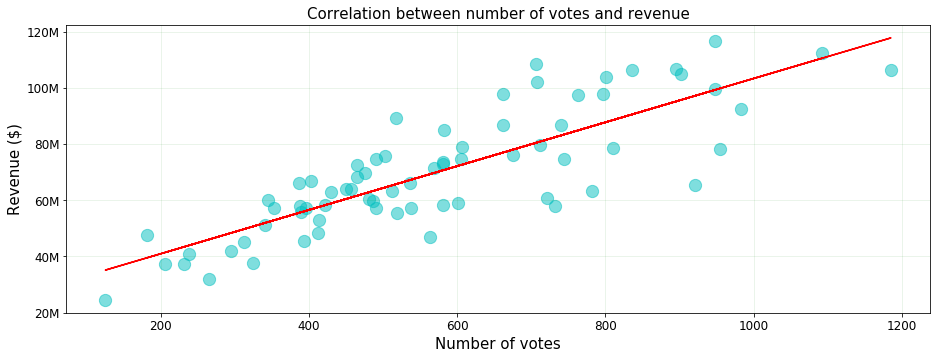

In [5]:
fig = plt.figure()
axes = fig.add_axes([0.1, 0.001, 2, 1])
axes.scatter(avg_vote_count, avg_revenue, alpha=0.5, s=150, color='c')
axes.set_title('Correlation between number of votes and revenue', fontsize=15)
axes.set_xlabel('Number of votes', fontsize=15)
axes.set_ylabel('Revenue ($)', fontsize=15)
axes.tick_params(labelsize=12)
formatter = FuncFormatter(millions)
axes.yaxis.set_major_formatter(formatter)
axes.plot(avg_vote_count, fit_vr[0]* np.array(avg_vote_count) + fit_vr[1], 'r')
axes.set_facecolor('white')
plt.grid(alpha=0.1, color='g')
plt.show()

Ugotovili smo, da obstaja korelacija med uspešnostjo filma, ki je definirana kot število glasov filma in njegovim zaslužkom. Iz grafa je razvidno, da sta spremenljivki linearno povezani. Med vsemi spremenljivkami, se je zaslužek izkazal, da najbolj vpliva na uspešnost filma.

In [6]:
genres_count = defaultdict(int)
genres_revenue = defaultdict(int)
genres_budget = defaultdict(int)

for movie in movies:
    if movie["budget"].value.isdigit() and movie["revenue"].value.isdigit():
        if float(movie["budget"].value) > 0.0 and float(movie["revenue"].value) > 0.0:
            for genre in json.loads(movie["genres"].value.replace("'", "\"")):
                genres_count[genre["name"]] += 1
                genres_budget[genre["name"]] += float(movie["budget"].value)
                genres_revenue[genre["name"]] += float(movie["revenue"].value)
    
for genre in genres_count:
    genres_budget[genre] = genres_budget[genre]/genres_count[genre]
    genres_revenue[genre] = genres_revenue[genre]/genres_count[genre]

genres, budgets = zip(*[(k, genres_budget[k]) for k in sorted(genres_budget, key=genres_budget.get, reverse=True)])
revenues = [genres_revenue[k] for k in sorted(genres_revenue, key=genres_revenue.get, reverse=True)]

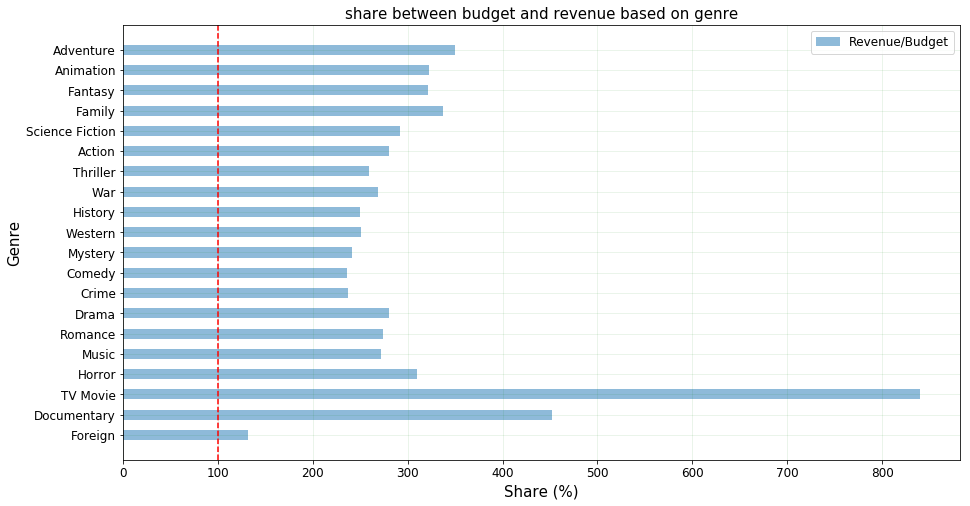

In [7]:
dataframe = []
for genre, budget, revenue in zip(genres, budgets, revenues):
    dataframe.append(["budget", genre, budget])
    dataframe.append(["revenue", genre, revenue])

    


raw_data = {'genres': genres,
        'budget': budgets,
        'revenue': revenues
           }
df = pd.DataFrame(raw_data, columns = ['genres', 'budget', 'revenue'])

share = []

for i in range(len(df['budget'])):
    share.append(100*(df['revenue'][i]/df['budget'][i]))

pos = list(range(len(df['budget']))) 
width = 0.5
    
fig, ax = plt.subplots(figsize=(15,8))


plt.barh([p + width for p in pos], share, width, alpha=0.5, label=df['genres'][1]) 

ax.set_xlabel('Share (%)', fontsize=15)
ax.set_ylabel('Genre', fontsize=15)
ax.set_title('share between budget and revenue based on genre', fontsize=15)
ax.set_yticks([p + 1 * width for p in pos])
ax.set_yticklabels(df['genres'])
ax.tick_params(labelsize=12)
ax.invert_yaxis()

ax.set_facecolor('white')
plt.grid(alpha=0.1, color='g')
plt.legend(['Revenue/Budget'], loc='upper right', prop={'size':12})
ax.axvline(x=100, color='red', linestyle="dashed")
plt.show()

Analizirali smo razmerje med dobičkom in vložkom za vsak žanr posebej. Izkazalo se je, da imajo neangleško govoreči filmi najmanj dobička, serije pa največ. Pri velini preostalih žanrov pa se razmerja gibljejo med 200 in 350 %.

In [8]:
trends = defaultdict(lambda: defaultdict(int))
for movie in movies:
    if "[{'id'" in movie["genres"].value:
        for genre in json.loads(movie["genres"].value.replace("'", "\"")):
            if movie["release_date"].value != "":
                trends[genre["name"]][parse(movie["release_date"].value).year] += 1


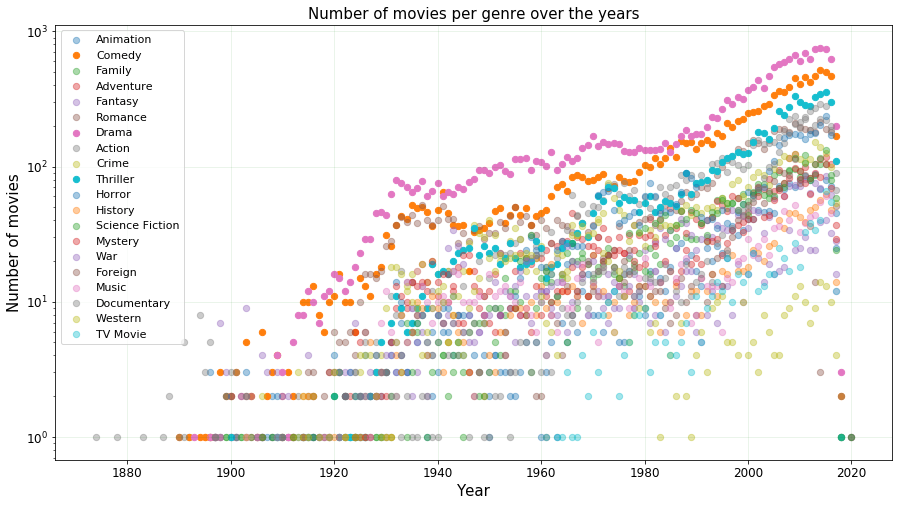

In [9]:
fig, ax = plt.subplots(figsize=(15, 8))
for genre in trends.keys():
    years, num_movies = zip(*[(k, trends[genre][k]) for k in sorted(trends[genre])])
    alfa = 0.4
    if genre in {"Drama", "Comedy", "Thriller"}:
        alfa = 1
    ax.scatter(years, num_movies, alpha=alfa, label=genre, s=40)
    ax.legend(loc=2, prop={'size':11})
    ax.tick_params(labelsize=12)
    ax.set_title("Number of movies per genre over the years",fontsize=15)
    ax.set_xlabel("Year",fontsize=15)
    ax.set_ylabel("Number of movies",fontsize=15)
    ax.set_yscale('log')
# ax.set_facecolor('white')
plt.grid(alpha=0.1, color='g')
plt.show()


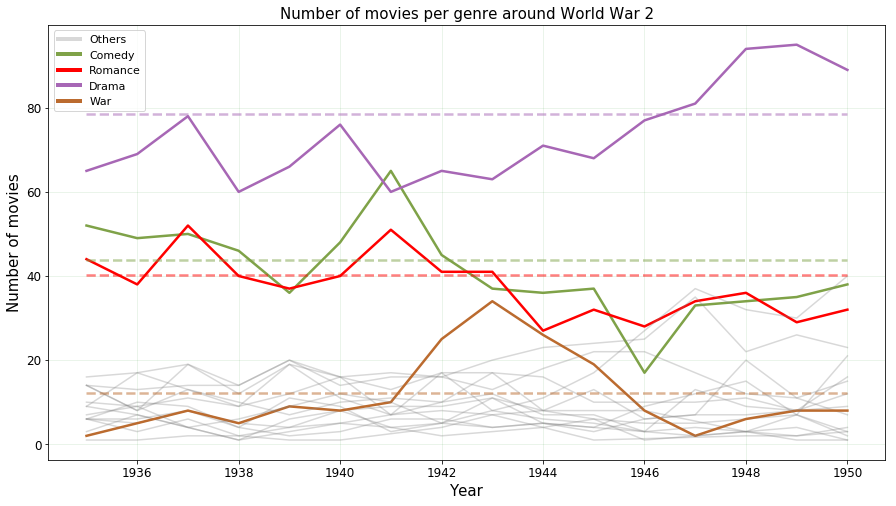

In [10]:
fig, ax = plt.subplots(figsize=(15, 8))
shown_genres = {"War", "Comedy", "Drama", "Romance"}
shown_genresAvg = {"WarAvg", "ComedyAvg", "DramaAvg", "RomanceAvg"}
for genre in shown_genres:
    avg_genre = sum([trends[genre][k] for k in sorted(trends[genre]) if 1935 <= k <= 1950])/15
    for i in range(1935, 1951):
        trends[genre+"Avg"][i] = avg_genre
dict_colors = {
    "War": "#bb6b2f",
    "Comedy": "#7fa248",
    "Drama": "#a767b5",
    "Romance": "red" 
}
for genre in trends.keys():
    cpy = [(k, trends[genre][k]) for k in sorted(trends[genre]) if 1935 <= k <= 1950]
    
    if len(cpy) == 0:
        years, num_movies = [], []
    else:
        years, num_movies = zip(*cpy)
        
    alfa = 0.3
    thickness = 1.5
    lbl = "Others"
    if genre in shown_genres:
        alfa = 1
        thickness = 2.5
        lbl = genre 
        ax.plot(years, num_movies, alpha=alfa, label=lbl, linewidth=thickness, color=dict_colors[genre])
    elif genre in  shown_genresAvg:
        alfa = 0.5
        thickness = 2.5
        lbl = genre 
        genre = genre.replace("Avg", "")
        ax.plot(years, num_movies, alpha=alfa, label=lbl, linewidth=thickness, color=dict_colors[genre], linestyle="dashed")
    else:
        ax.plot(years, num_movies, alpha=alfa, label=lbl, linewidth=thickness, c='grey')
        
    ax.set_title("Number of movies per genre around World War 2", fontsize=15)
    ax.set_xlabel("Year", fontsize=15)
    ax.set_ylabel("Number of movies", fontsize=15)


for line in ax.legend().get_lines():
    line.set_linewidth(2.0)

    
ax.tick_params(labelsize=12)

def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(4.0)

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in shown_genresAvg and label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)

ax.legend(newHandles, newLabels, loc=2, prop={'size':11}, handler_map={plt.Line2D : HandlerLine2D(update_func=update)})  

ax.set_facecolor('white')
plt.grid(alpha=0.1, color='g')
plt.show()

Analiza 4 najbolj popularnih žanrov med drugo svetovno vojno. Vidno je, da je število komedij precej naraslo takoj po začetku 2. svetovne vojne. Proti koncu vojne je šele naraslo število vojnih filmov. Pokazalo se je, da jih je bilo kar enkrat več v tem obdobju. 

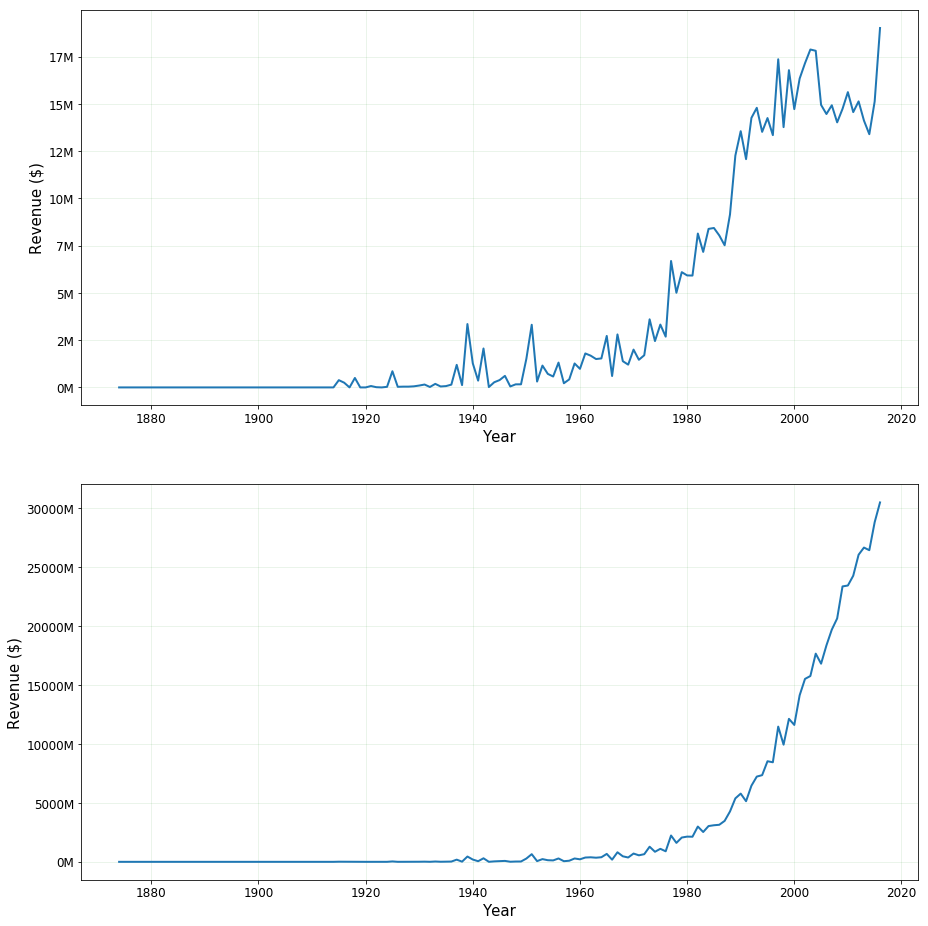

In [11]:
df = pd.read_csv('data/movies_metadata.csv',low_memory=False)
df['release_date'] = df['release_date'].map(set_year)
df = df[df.apply(lambda x: x['release_date'] != 200000, axis=1)]
df['release_year'] = df['release_date'].map(parse_year)
df = df[df.release_year < 2017]


sum_revenue_by_year = df.groupby(['release_year'], as_index=False)['revenue'].sum()
mean_revenue_by_year = df.groupby(['release_year'], as_index=False)['revenue'].mean()

fig, ax = plt.subplots(2,  1, figsize=(15, 16))


p1 = pd.DataFrame(mean_revenue_by_year).plot(x='release_year', y="revenue", ax=ax[0], legend=False, linewidth=2.0)
p2 = pd.DataFrame(sum_revenue_by_year).plot(x='release_year', y="revenue", ax=ax[1], legend=False, linewidth=2.0)

for p in [p1, p2]:
    p.set_facecolor("white")
    p.tick_params(labelsize=12)
    p.set_xlabel("Year", fontsize=15)
    p.set_ylabel("Revenue ($)", fontsize=15)
    formatter = FuncFormatter(millions)
    p.yaxis.set_major_formatter(formatter)
    p.grid(alpha=0.1, color='g')


plt.show()

Zgornji sliki prikazujeta vsoto in povprečje prihodkov skozi čas.

Zgornji podatki so zavajujoči, ker nismo upoštevali inflacije. Na spodnji sliki je pa upoštevana še inflacija. Modul ne vsebuje podatkov inflacije pred letom 1960, zato so smo za predhodna leta uporabili kar vrednost denarna iz leta 1960.

In [12]:
ep = EasyPeasy()

In [13]:
for index, row in df.iterrows():
    df.set_value(index, 'revenue_normed', ep.normalize(amount=row['revenue'], region="USA", from_year=row['release_year'], to_year="latest", pretty_print=False))

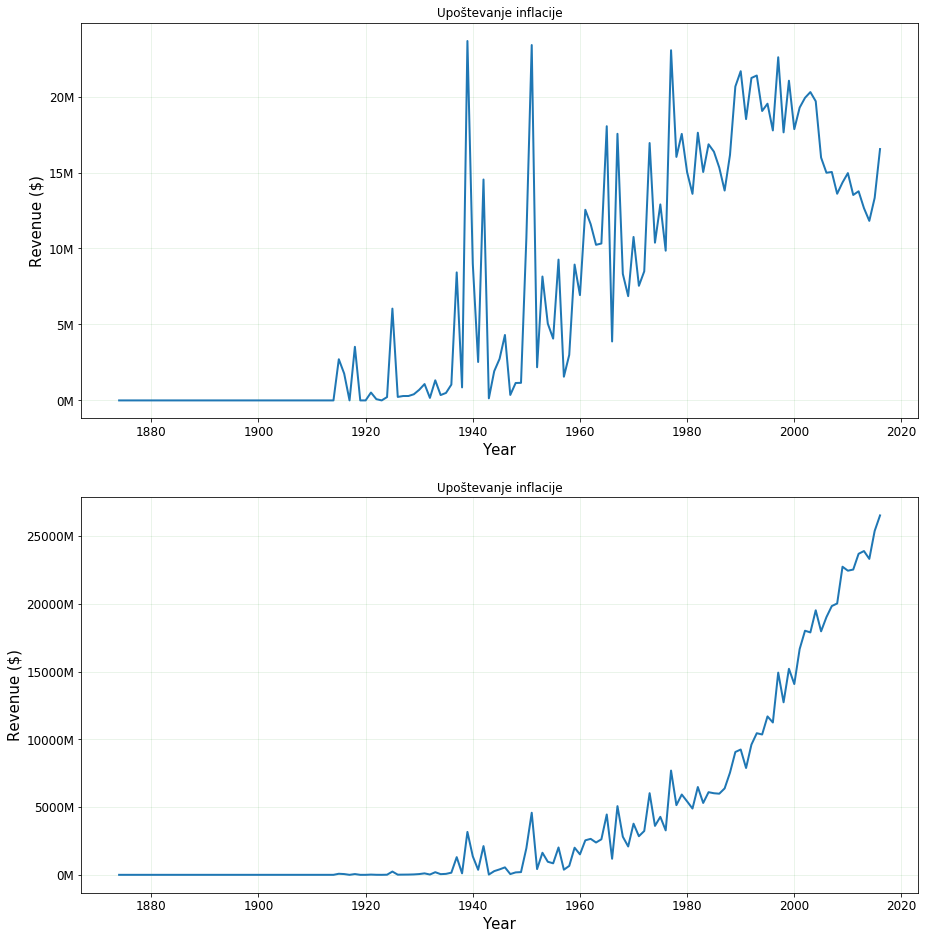

In [14]:
sum_revenue_by_year = df.groupby(['release_year'], as_index=False)['revenue_normed'].sum()
mean_revenue_by_year = df.groupby(['release_year'], as_index=False)['revenue_normed'].mean()


fig, ax = plt.subplots(2,  1, figsize=(15, 16))

p1 = pd.DataFrame(mean_revenue_by_year).plot(x='release_year', y="revenue_normed", ax=ax[0], legend=False, linewidth=2.0)
p2 = pd.DataFrame(sum_revenue_by_year).plot(x='release_year', y="revenue_normed", ax=ax[1], legend=False, linewidth=2.0)

for p in [p1, p2]:
    p.set_facecolor("white")
    p.tick_params(labelsize=12)
    p.set_xlabel("Year", fontsize=15)
    p.set_ylabel("Revenue ($)", fontsize=15)
    formatter = FuncFormatter(millions)
    p.yaxis.set_major_formatter(formatter)
    p.grid(alpha=0.1, color='g')
    p.set_title("Upoštevanje inflacije")

plt.show()

# Zemljevid, ki prikazuje najbolj snemane žanre v državi za vsako leto
![gif](readme_images/map.gif)
Druge hitrosti:

- [0.2s zamik](readme_images/map-0.2s-delay.gif)
- [2s zamik](readme_images/map-2s-delay.gif)

Prvi začetki filmov so bili leta 1874 v Franciji, kasneje pa sta začeli snemati filme še Velika Britanija in Združene države Amerike. Veliko let ni bilo nobene druge države. V 20. stoletju pa so začeli prihajati filmi še iz drugih držav.

Prvi žanr za katerega imamo podatke je bil dokumentarni film. Ta žanr se je pojavljal nekaj let, kasneje pa se mu je pridružila komedija. Do leta 2017 se je pojavilo 20 različnih žanrov.